<a href="https://colab.research.google.com/github/aaalexlit/tf-advanced-techniques-spec/blob/main/course_1_custom_models%20/Week1_Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement a Siamese network
## Imports

In [29]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare the Dataset
### Define the utilities

In [30]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
          z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
          # add positive pair
          pairs += [[x[z1], x[z2]]]
          inc = random.randrange(1, 10)
          dn = (d + inc) % 10
          # add negative pair
          z1, z2 = digit_indices[d][i], digit_indices[dn][i]
          pairs += [[x[z1], x[z2]]]
          labels += [1, 0]
    
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')
  return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image, cmap='Greys')
  # plt.colorbar()
  plt.grid(False)
  plt.show()

In [31]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# convert to float32 for TF as original set dtype is uint
train_images, test_images = train_images.astype('float32'), test_images.astype('float32')

# make the pixel values be between 0 and 1
train_images = train_images / 255.
test_images = test_images / 255.

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

## Visualize random image pairs

Show a random image pair and then the following. 
One pair is of the same items and the other - different by construction

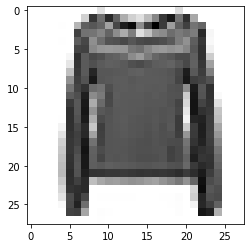

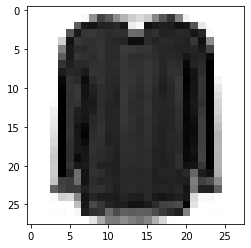

1.0


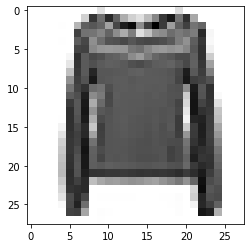

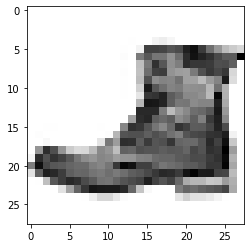

0.0


In [32]:
this_pair_idx = random.choice(range(len(ts_pairs)))
# show images at this index
show_image(ts_pairs[this_pair_idx][0])
show_image(ts_pairs[this_pair_idx][1])

# print the label for this pair
print(ts_y[this_pair_idx])


show_image(ts_pairs[this_pair_idx+1][0])
show_image(ts_pairs[this_pair_idx+1][1])

print(ts_y[this_pair_idx+1])

## Visualize the first pairs from training

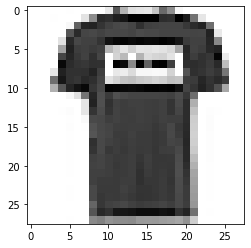

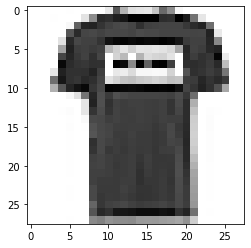

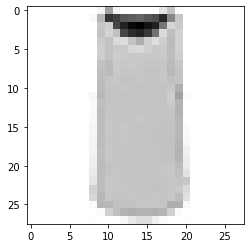

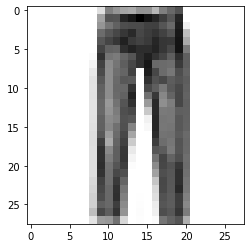

In [33]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build the model
### Define utilities to build the model

In [34]:
def initialize_base_network():
  input = Input(shape=(28, 28, ), name="base_input")
  x = Flatten(name="flatten_input")(input)
  x = Dense(128, activation='relu', name="first_base_dense")(x)
  x = Dropout(0.1, name="first_dropout")(x)
  x = Dense(128, activation='relu', name="second_base_dense")(x)
  x = Dropout(0.1, name="second_dropout")(x)
  x = Dense(128, activation='relu', name="third_base_dense")(x)

  return Model(inputs=input, outputs=x)


def euclidean_distance(vectors):
  x, y = vectors
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

## Build and visualize Base Network

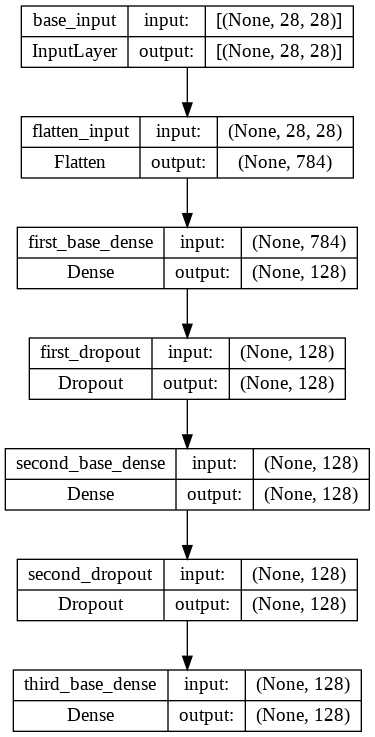

In [35]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True)

## Build and visualize Siamese networs

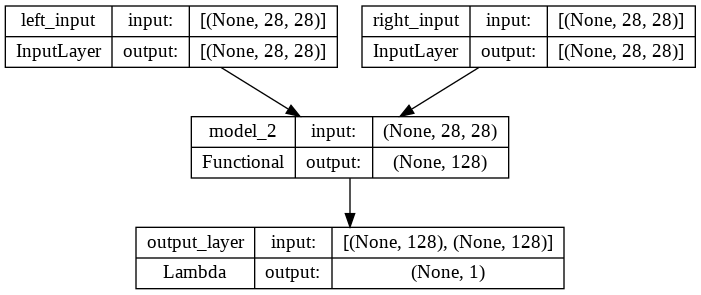

In [36]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True)

## Train the model
### Define custom loss function

In [37]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [38]:
def compute_accuracy(y_true, y_pred):
  # make predictions a 1D array and 
  # put a threshold of 0.5 to convert them to binary format
  pred = y_pred < 0.5
  y_true = tf.cast(y_true, pred.dtype)
  return K.mean(pred == y_true)

### Train the model

In [39]:
rms_optimizer = RMSprop()
model.compile(loss=contrastive_loss_with_margin(1), 
              optimizer=rms_optimizer,
              metrics=[compute_accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], 
                    tr_y,
                    epochs=10, 
                    batch_size=128,
                    validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/10
938/938 [==============================] - 11s 10ms/step - loss: 0.1099 - compute_accuracy: 0.8583 - val_loss: 0.0873 - val_compute_accuracy: 0.8784
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0800 - compute_accuracy: 0.8982 - val_loss: 0.0745 - val_compute_accuracy: 0.9057
Epoch 3/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0717 - compute_accuracy: 0.9092 - val_loss: 0.0729 - val_compute_accuracy: 0.9034
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0670 - compute_accuracy: 0.9150 - val_loss: 0.0678 - val_compute_accuracy: 0.9089
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0634 - compute_accuracy: 0.9193 - val_loss: 0.0676 - val_compute_accuracy: 0.9081
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0610 - compute_accuracy: 0.9200 - val_loss: 0.0672 - val_compute_accuracy: 0.9075
Epoch 7/10
938/938 [=======================

## Model evaluation
We need to compute accuracy by thresholding the output values cause they are Euclidean distance not 0s and 1s as the input

In [40]:
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='b', label=metric_name)  
  plt.plot(history.history[f'val_{metric_name}'], color='g', label=f'val_{metric_name}')


# matplotlib config
def visualize_images():
  plt.rc('image', cmap='grey_r')
  plt.rc('grid', linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('ytick', left=False, right=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
  plt.rc('text', color='a8151a')
  plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left, cmap='Greys')
    plt.figure(figsize=(17,3))
    plt.yticks([])
    lab_titles = ['dissimilar', 'similar']
    tick_labels = [f'distance = {p:.3f}\ntrue:{lab_titles[int(l)]}\npred:{lab_titles[int(p < 0.5)]}' 
                   for (p, l) in zip(predictions, labels)]
    plt.xticks([28*x+14 for x in range(n)], tick_labels)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if int(predictions[i] < 0.5) != labels[i]: t.set_color('red') # incorrect predictions
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right, cmap='Greys')

In [41]:
test_eval = model.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y=ts_y)
train_eval = model.evaluate(x=[tr_pairs[:, 0], tr_pairs[:, 1]], y=tr_y)

print(f"Test Loss = {test_eval[0]:.3f}, Test Accuracy = {test_eval[1]:.3f},\nTrain Loss = {train_eval[0]:.3f}, Train Accuracy = {train_eval[1]:.3f}")

3750/3750 [==============================] - 8s 2ms/step - loss: 0.0523 - compute_accuracy: 0.9308
Test Loss = 0.064, Test Accuracy = 0.912,
Train Loss = 0.052, Train Accuracy = 0.931


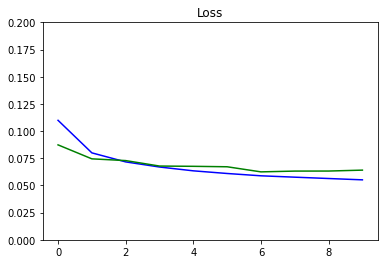

In [42]:
plot_metrics(metric_name='loss', title='Loss', ylim=0.2)

In [43]:
y_pred_test = np.squeeze(model.predict([ts_pairs[:,0], ts_pairs[:,1]]))

625/625 [==============================] - 1s 2ms/step


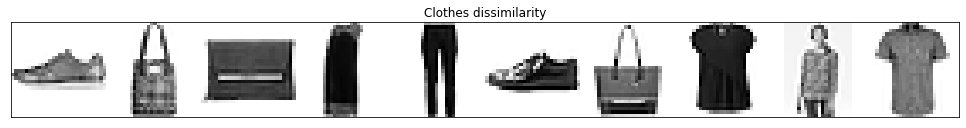

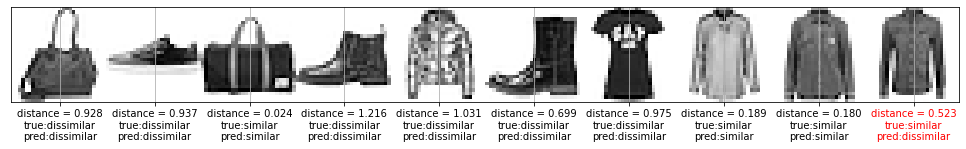

In [44]:
indexes = np.random.choice(len(y_pred_test), size=10)
display_images(ts_pairs[:, 0][indexes], 
               ts_pairs[:, 1][indexes], 
               y_pred_test[indexes], 
               ts_y[indexes],
               'Clothes dissimilarity',
               10)